In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
from sklearn.metrics import accuracy_score
from utils import transforms, exports

split_path = Path("results/split")

In [2]:
with exports.JSONExporter(Path("analysis") / "train-sizes.json") as data:
    dim_splits = data["train_sizes"]

In [3]:
values = np.load(
    split_path / "results_split_5_mamba_mw_1.7.npy",
    allow_pickle=True,
).item()
terrains = np.array([t for t in values["terrains"] if t != "MIXED"])
inv_terrains = {t: i for i, t in enumerate(terrains)}

In [4]:
res_cnn = []
res_mamba = []
for p in sorted(split_path.iterdir()):
    if "CNN" in p.stem:
        res_cnn.append(np.load(p, allow_pickle=True).item())
    elif "mamba" in p.stem:
        res_mamba.append(np.load(p, allow_pickle=True).item())

In [5]:
cnn_acc_per_split = []
mamba_acc_per_split = []
for res in res_cnn[::-1]:
    ypred = transforms.convert_to_idx(res["pred"], inv_terrains)
    ytest = transforms.convert_to_idx(res["true"], inv_terrains)
    fold_size = len(ypred) // 5
    print(fold_size)
    acc = []
    for k in range(5):
        pred = ypred[k * fold_size : (k + 1) * fold_size]
        true = ytest[k * fold_size : (k + 1) * fold_size]
        acc.append(accuracy_score(true, pred))
    cnn_acc_per_split.append(acc)

for res in res_mamba[::-1]:
    ypred = transforms.convert_to_idx(res["pred"], inv_terrains)
    ytest = transforms.convert_to_idx(res["true"], inv_terrains)
    fold_size = len(ypred) // 5
    print(fold_size)
    acc = []
    for k in range(5):
        pred = ypred[k * fold_size : (k + 1) * fold_size]
        true = ytest[k * fold_size : (k + 1) * fold_size]
        acc.append(accuracy_score(true, pred))
    mamba_acc_per_split.append(acc)



print(f"{cnn_acc_per_split=}")
print(f"{mamba_acc_per_split=}")

828
828
828
828
828
3945
3945
3945
3945
3945
cnn_acc_per_split=[[0.7946859903381642, 0.6823671497584541, 0.714975845410628, 0.6666666666666666, 0.7125603864734299], [0.8466183574879227, 0.785024154589372, 0.8128019323671497, 0.7922705314009661, 0.7439613526570048], [0.8997584541062802, 0.8357487922705314, 0.8707729468599034, 0.8417874396135265, 0.8369565217391305], [0.927536231884058, 0.8695652173913043, 0.8804347826086957, 0.8659420289855072, 0.8611111111111112], [0.9371980676328503, 0.9033816425120773, 0.9178743961352657, 0.8900966183574879, 0.8792270531400966]]
mamba_acc_per_split=[[0.6136882129277567, 0.6002534854245881, 0.644106463878327, 0.6159695817490495, 0.5837769328263624], [0.7731305449936628, 0.720659062103929, 0.7254752851711027, 0.7158428390367554, 0.7057034220532319], [0.8359949302915083, 0.8337135614702155, 0.8144486692015209, 0.8347275031685678, 0.8195183776932826], [0.8732572877059569, 0.908745247148289, 0.8699619771863117, 0.873510773130545, 0.8623574144486692], [0.9

In [6]:
x = np.array(dim_splits)[::-1]

cnn_acc = np.mean(cnn_acc_per_split, axis=1)
mamba_acc = np.mean(mamba_acc_per_split, axis=1)

cnn_err = 1-cnn_acc
mamba_err = 1-mamba_acc

cnn_bars = 1 - np.percentile(cnn_acc_per_split, [75, 25], axis=1).T
mamba_bars = 1 - np.percentile(mamba_acc_per_split, [75, 25], axis=1).T

COLORS = {
    "CNN": "mediumvioletred",
    "MAMBA": "teal",
}

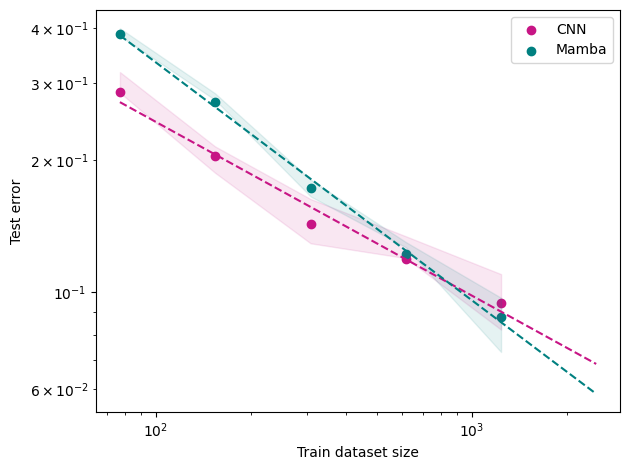

In [8]:

fig, ax = plt.subplots()

ax.scatter(x, cnn_err, label="CNN", color=COLORS["CNN"])
ax.scatter(x, mamba_err, label="Mamba", color=COLORS["MAMBA"])

ax.fill_between(x, cnn_bars[:, 0], cnn_bars[:, 1], alpha=0.1, color=COLORS["CNN"])
ax.fill_between(x, mamba_bars[:, 0], mamba_bars[:, 1], alpha=0.1, color=COLORS["MAMBA"])

xlog = np.log(x)

# cnn_trend = np.poly1d(np.polyfit(np.log2(x), cnn_err, 2))
# mamba_trend = np.poly1d(np.polyfit(np.log2(x), mamba_err, 2))
cnn_trend = np.poly1d(np.polyfit(xlog, np.log(cnn_err), 1))
mamba_trend = np.poly1d(np.polyfit(xlog, np.log(mamba_err), 1))

# x_trend
ratio = x[-1] / x[-2]
x_extend = x[-1] * ratio ** np.arange(2)
x_trend = np.hstack([x[:-1], x_extend])
# x_trend = x

cnn_fit = lambda x: np.exp(cnn_trend(np.log(x)))
mamba_fit = lambda x: np.exp(mamba_trend(np.log(x)))

ax.loglog(x_trend, cnn_fit(x_trend), linestyle="--", color=COLORS["CNN"])
ax.loglog(x_trend, mamba_fit(x_trend), linestyle="--", color=COLORS["MAMBA"])

# ax.set_yticks(np.arange(0.60, 1.05, 0.05))

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Train dataset size")
ax.set_ylabel("Test error")

ax.legend(loc="best")
fig.tight_layout()
fig.savefig("analysis/train-sizes.pdf", bbox_inches="tight")
